In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import CubicSpline

In [2]:
opts_path = "/data/workspace_files/Henry_2010_vols.csv"
futs_path = "/data/workspace_files/Henry_2010_futs.csv"
opts_prices = pd.read_csv(opts_path)
opts_prices = opts_prices
#opts_prices["Days_to_Expiry"] = opts_prices["Days_to_Expiry"] - 30 ### coz chatgpt is dumb and didnt account for month ahead expiry for hh options, not needed usually
opts_prices["50D"] = opts_prices["50D"] / 100
opts_prices.head()

,Futures,Contracts,Days_to_Expiry,50D
0,5.41,10-May,60,0.4533
1,5.55,10-Jun,91,0.4262
2,5.72,10-Jul,121,0.4188
3,5.82,10-Aug,152,0.4333
4,5.90,10-Sep,183,0.4546


In [3]:
# Black-Scholes option price (Black model for futures)
def black_model_option_price(F, K, T, r, sigma, option_type='call'):
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type == 'put':
        option_price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return option_price

# N-factor variance calculation
def get_factor_variance(sigma, kappa, T_Fut, T_opt):
    if kappa == 0:
        return sigma**2 * T_opt
    else:
        return sigma**2 * (np.exp(-2 * kappa * (T_Fut - T_opt)) - np.exp(-2 * kappa * T_Fut)) / (2 * kappa)

# N-factor cross-variance calculation (no sqrt required)
def get_cross_factor_variance(sigma1, sigma2, kappa1, kappa2, rho, T_Fut, T_opt):
    cross_variance = sigma1 * sigma2 * rho
    kappa = (kappa1 + kappa2) / 2
    return cross_variance * (np.exp(-2 * kappa * (T_Fut - T_opt)) - np.exp(-2 * kappa * T_Fut)) / (2 * kappa)

# N-factor option price calculation
def get_n_factor_variance(T_Fut, T_opt, sigmas, kappas, correlation_matrix):
    n = len(sigmas)
    total_variance = 0.0

    # Calculate individual factor variances
    for i in range(n):
        total_variance += get_factor_variance(sigmas[i], kappas[i], T_Fut, T_opt)

    # Calculate cross-factor variances
    for i in range(n):
        for j in range(i + 1, n):
            total_variance += 2 * get_cross_factor_variance(sigmas[i], sigmas[j], kappas[i], kappas[j],
                                                            correlation_matrix[i, j], T_Fut, T_opt)

    # Total volatility is the square root of total variance
    total_variance = total_variance / T_opt

    return total_variance

# Helper function to create masks for free and fixed parameters
def create_parameter_masks(fixed_params, n):
    total_params = 2 * n + (n * (n - 1)) // 2
    param_mask = np.zeros(total_params)  # Mask for all parameters (sigmas, kappas, and correlations)
    fixed_values = np.zeros(total_params)  # Array to store fixed values

    for key, value in fixed_params.items():
        if key.startswith('sigma'):
            idx = int(key.split('_')[1]) - 1
            param_mask[idx] = 1
            fixed_values[idx] = value
        elif key.startswith('kappa'):
            idx = n + int(key.split('_')[1]) - 1
            param_mask[idx] = 1
            fixed_values[idx] = value
        elif key.startswith('rho'):
            i, j = map(int, key.split('_')[1:])
            corr_index = 2 * n + (i - 1) * (n - i // 2) + (j - i - 1)
            param_mask[corr_index] = 1
            fixed_values[corr_index] = value
    return param_mask, fixed_values

# Objective function for calibrating to implied volatility
def objective_function_volatility(free_params, market_variance, T_Fut, T_opt, r, n, fixed_params, param_mask):
    params = np.zeros_like(param_mask)
    params[param_mask == 0] = free_params  # Free parameters from optimizer
    params[param_mask == 1] = fixed_params[param_mask == 1]

    # Extract sigmas, kappas, and correlations
    sigmas = params[:n]
    kappas = params[n:2*n]
    correlation_values = params[2*n:]

    # Build the correlation matrix
    correlation_matrix = np.eye(n)
    index = 0
    for i in range(n):
        for j in range(i + 1, n):
            correlation_matrix[i, j] = correlation_values[index]
            correlation_matrix[j, i] = correlation_values[index]
            index += 1

    model_variance = []

    # Calculate model-implied volatilities for all options
    for i in range(len(market_volatilities)):
        model_var = get_n_factor_variance(T_Fut[i], T_opt[i], sigmas, kappas, correlation_matrix)
        model_variance.append(model_var)

    # Squared difference between market and model volatilities
    error = np.sum((np.array(market_variance) - np.array(model_variance)) ** 2)

    return error

# Calibration function to find optimal sigmas, kappas, and correlations directly to volatilities
def calibrate_n_factors_to_volatility(market_volatilities, T_Fut, T_opt, r, n, fixed_params):
    market_variance = [x**2 for x in market_volatilities]

    initial_guess_sigmas = [0.2] * n  # Initial guess for volatilities
    initial_guess_kappas = [0.1] * n  # Initial guess for mean-reversion rates
    initial_guess_correlations = [0.5] * (n * (n - 1) // 2)  # Initial guess for correlations

    initial_guess = initial_guess_sigmas + initial_guess_kappas + initial_guess_correlations

    # Create parameter masks and fixed values
    param_mask, fixed_values = create_parameter_masks(fixed_params, n)

    # Only optimize over free parameters
    free_initial_guess = np.array(initial_guess)[param_mask == 0]

    # Bounds for sigmas, kappas, and correlations
    bounds_sigmas = [(0.01, 1.0)] * n
    bounds_kappas = [(0.01, 10.0)] * n
    bounds_correlations = [(-1, 1)] * (n * (n - 1) // 2)

    bounds = bounds_sigmas + bounds_kappas + bounds_correlations
    free_bounds = np.array(bounds)[param_mask == 0]  # Bounds only for free parameters

    # Minimize the objective function
    result = minimize(objective_function_volatility, free_initial_guess, bounds=free_bounds,
                      args=(market_variance, T_Fut, T_opt, r, n, fixed_values, param_mask))

    # Return the optimized free parameters
    optimized_free_params = result.x
    full_params = np.zeros(len(param_mask))
    full_params[param_mask == 0] = optimized_free_params
    full_params[param_mask == 1] = fixed_values[param_mask == 1]

    optimized_sigmas = full_params[:n]
    optimized_kappas = full_params[n:2*n]
    optimized_correlations = full_params[2*n:]

    return optimized_sigmas, optimized_kappas, optimized_correlations

In [4]:

# Sample data for testing
t = 0  # Current time
times = opts_prices["Days_to_Expiry"].to_numpy()/365  # Future times
implied_vols = opts_prices["50D"].to_numpy()  # Sample implied volatilities

# Example data for calibration
F = times  # Futures prices
K = times  # Strike prices
T_Fut = times  # Futures expiry in years
T_opt = times # Option expiry in years
r = 0.02  # Risk-free rate
market_volatilities = implied_vols  # Market-observed volatilities (example)



# Number of factors (e.g., 3 factors)
n = 1

# Example fixed parameters (e.g., fixing sigma_1 and rho_12)
fixed_params = {
   # "kappa_3": 0
}

# Perform the calibration to volatilities
sigmas_opt, kappas_opt, correlations_opt = calibrate_n_factors_to_volatility(
    market_volatilities, T_Fut, T_opt, r, n, fixed_params
)

# Build the correlation matrix
correlation_matrix = np.eye(n)
index = 0
for i in range(n):
    for j in range(i + 1, n):
        correlation_matrix[i, j] = correlations_opt[index]
        correlation_matrix[j, i] = correlations_opt[index]
        index += 1
# Output the optimized parameters
print(f"Calibrated sigmas: {sigmas_opt}")
print(f"Calibrated kappas: {kappas_opt}")
print(f"Calibrated correlations: {correlations_opt}")

Calibrated sigmas: [0.49963259]
Calibrated kappas: [0.78123042]
Calibrated correlations: []


In [5]:
opts_prices["Fitted_vols"] = opts_prices.apply(lambda row: np.sqrt(get_n_factor_variance(row["Days_to_Expiry"]/365, row["Days_to_Expiry"]/365, sigmas_opt, kappas_opt, correlation_matrix )
),axis=1)

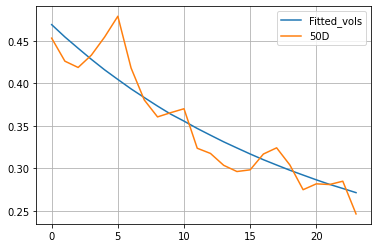

In [6]:
opts_prices[["Fitted_vols", "50D"]].plot()
plt.grid()

In [7]:
sig, alpha = sigmas_opt[0], kappas_opt[0]

In [11]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Constants and parameters
sigma = 0.66102746  # Volatility
kappa = 1.20127041  # Mean reversion
r = 0.02/12  # Risk-free rate

delta_t = 1 / 12  # Time step (1 month)

 # Number of inventory steps
time_N = 40 * 12  # Number of time steps

MSQ = 1e6  # Maximum Storage Quantity
mdiq_day = 6250  # Maximum daily injection quantity
mdwq_day = 6250  # Maximum daily withdrawal quantity
num_days = 30  # Period of 30 days
mdiq = mdiq_day * num_days  # Total maximum injection over the period
mdwq = mdwq_day * num_days  # Total maximum withdrawal over the period
inj_cost = 0.015  # Injection cost per unit
withdraw_cost = 0.01  # Withdrawal cost per unit
inj_rate = mdiq / MSQ  # Injection rate (fraction of capacity)
withdraw_rate = mdwq / MSQ  # Withdrawal rate (fraction of capacity)
max_injection = inj_rate*MSQ  # Maximum injection rate
max_withdrawal = withdraw_rate*MSQ  # Maximum withdrawal rate
fuel_cost = 2.5e-2  # Fuel cost for injection

inv_N = int(MSQ/mdiq )+1
# Discretization
max_phi = 0.9
min_phi = -max_phi
phi_N = int(1000 / (np.sqrt(delta_t) * (max_phi - min_phi))) + 1  # Number of steps for Phi

delta_phi = (max_phi - min_phi) / (phi_N - 1)

# Valuation grid
V = np.zeros((time_N, phi_N, inv_N))
V[-1, :, 1:] = -1e12  # Penalty for remaining inventory at expiration

# Define the forward expirations and prices (replace with your actual data)
forward_prices = np.array(opts_prices["Futures"])  # in years

forward_expirations= (np.array(opts_prices['Days_to_Expiry']))/365  # corresponding forward prices
# Sort the forward expirations and corresponding prices
sorted_indices = np.argsort(forward_expirations)
forward_expirations = forward_expirations[sorted_indices]
forward_prices = forward_prices[sorted_indices]

# Create the cubic spline interpolator
cs = CubicSpline(forward_expirations, forward_prices, extrapolate=True)


# Times at which we need the forward prices
times_needed = np.array([i * delta_t for i in range(time_N)])

# Compute the forward prices at these times using the cubic spline interpolator
precomputed_forward_prices = cs(times_needed)

# Ensure the array is of type float64 for Numba compatibility
precomputed_forward_prices = precomputed_forward_prices.astype(np.float64)


@njit
def calculate_forward_price(time ):
    # For now, assume forward price is constant
    return precomputed_forward_prices[time]  # Example: $1 per unit

@njit
def calculate_spot_price(i, j, delta_phi, min_phi, sigma, kappa, delta_t):
    time = i * delta_t
    phi = j * delta_phi + min_phi
    term1 = -(sigma ** 2) * (1 - np.exp(-2 * kappa * time)) / (4 * kappa)
    forward_price = calculate_forward_price(i)
    exponent = term1 + sigma * phi
    # Prevent overflow
    #exponent = np.clip(exponent, -700, 700)
    return forward_price * np.exp(exponent)

@njit
def calculate_injection_charges(i, j, k, inv_N, max_injection, fuel_cost, sigma, kappa, delta_t):
    if k >= inv_N - 1:  # Max inventory
        return float('-inf')  # Infeasible to inject more
    spot = calculate_spot_price(i, j, delta_phi, min_phi, sigma, kappa, delta_t)
    inj_cost_spot = spot * max_injection * (1 + fuel_cost)
    inj_cost_comm = inj_cost * max_injection
    return - (inj_cost_spot + inj_cost_comm)

@njit
def calculate_withdrawal_charges(i, j, k, inv_N, max_withdrawal, withdraw_cost, sigma, kappa, delta_t):
    if k <= 0:  # Minimum inventory
        return float('-inf')  # Infeasible to withdraw more
    spot = calculate_spot_price(i, j, delta_phi, min_phi, sigma, kappa, delta_t)
    withdrw_spot_pay = spot * max_withdrawal
    withdrw_cost_comm = withdraw_cost * max_withdrawal
    return withdrw_spot_pay - withdrw_cost_comm

@njit
def tridiagonal_solver(a, b, c, d):
    n = len(d)
    cp = np.zeros(n - 1)
    dp = np.zeros(n)

    # Forward sweep
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, n-1 ):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom
    denom = b[-1] - a[-1] * cp[-2]
    dp[-1] = (d[-1] - a[-1] * dp[-2]) / denom

    # Backward substitution
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]
    return x

@njit
def solve_implicit_time_step(V_next, delta_phi, delta_t, kappa, r, phi_N):
    delta_phi_sq = delta_phi ** 2
    N = phi_N  # Include boundary points

    a = np.zeros(N)  # Coefficients for V_{i-1}^{n}
    b = np.zeros(N)  # Coefficients for V_i^{n}
    c = np.zeros(N)  # Coefficients for V_{i+1}^{n}
    d = np.zeros(N)  # Right-hand side (RHS) vector

    for idx in range(N):
        phi_j = min_phi + idx * delta_phi  # Calculate phi at point idx

        C = delta_t * kappa * phi_j / (2 * delta_phi)  # Advection term coefficient
        D = delta_t /  (2*delta_phi_sq)  # Diffusion term coefficient

        if idx == 0:
            # Left boundary node (V[0] equation)
            a[idx] = 0  # No V_{-1}^{n} term
            b[idx] = 1 + 2 * D + delta_t * r  # Coefficient of V_0^{n}
            c[idx] = C -D  # Coefficient of V_1^{n}

            # Right-hand side uses V_0^n and V_1^n (current time step values)
            d[idx] = V_next[idx]  # Use V_0^n directly on the RHS

        elif idx == N - 1:
            # Right boundary node (V[N-1] equation) - Use backward difference for second derivative
            a[idx] = C + D  # Coefficient of V_{N-2}^{n}
            b[idx] = 1 + 2 * D + delta_t * r  # Coefficient of V_{N-1}^{n}
            c[idx] = 0  # No V_N^{n} term

            # Right-hand side uses V_{N-2}^n and V_{N-1}^n
            d[idx] = V_next[idx]  # Use V_{N-1}^n directly on the RHS

        else:
            # Interior nodes (V[i] equation for i in [1, N-2])
            a[idx] = -C - D  # Coefficient of V_{i-1}^{n}
            b[idx] = 1 +  2*D + delta_t * r  # Coefficient of V_{i}^{n}
            c[idx] = C - D  # Coefficient of V_{i+1}^{n}

            # Right-hand side at interior points
            d[idx] = V_next[idx]  # Use V_i^n directly on the RHS

    # Solve the tridiagonal system for V^{n+1} (future time step)
    V_new = tridiagonal_solver(a, b, c, d)  # Solve A * V_new = V_current

    return V_new
    
@njit
def time_stepping(V, time_N, phi_N, inv_N, delta_phi, delta_t, kappa, sigma, r,
                  max_injection, fuel_cost, max_withdrawal, withdraw_cost):
    for i in range(time_N - 2, -1, -1):  # Step backward in time
        for k in range(inv_N):
            # Hold option
            V_hold = solve_implicit_time_step(
                V[i + 1, :, k], delta_phi, delta_t, kappa, r, phi_N)

            # Injection option
            if k < inv_N - 1:
                V_inject = solve_implicit_time_step(
                    V[i + 1, :, k + 1], delta_phi, delta_t, kappa, r, phi_N)
                # Add action costs after solving the PDE
                action_costs_inject = np.zeros(phi_N)
                for j in range(phi_N):
                    action_costs_inject[j] = calculate_injection_charges(
                        i, j, k, inv_N, max_injection, fuel_cost, sigma, kappa, delta_t)
                V_inject += action_costs_inject
            else:
                V_inject = np.full(phi_N, float('-inf'))

            # Withdrawal option
            if k > 0:
                V_withdraw = solve_implicit_time_step(
                    V[i + 1, :, k - 1], delta_phi, delta_t, kappa, r, phi_N)
                # Add action costs after solving the PDE
                action_costs_withdraw = np.zeros(phi_N)
                for j in range(phi_N):
                    action_costs_withdraw[j] = calculate_withdrawal_charges(
                        i, j, k, inv_N, max_withdrawal, withdraw_cost, sigma, kappa, delta_t)
                V_withdraw += action_costs_withdraw
            else:
                V_withdraw = np.full(phi_N, float('-inf'))

            # Choose the optimal action at each state
            for j in range(phi_N):
                V[i, j, k] = max(V_hold[j], V_inject[j], V_withdraw[j])

    return V

# Run time-stepping method
V = time_stepping(V, time_N, phi_N, inv_N, delta_phi, delta_t, kappa, sigma, r,
                  max_injection, fuel_cost, max_withdrawal, withdraw_cost)

# Example: Plotting the value function at initial time for a specific inventory level
inventory_level = 0  # Middle inventory level
phi_values = np.linspace(min_phi, max_phi, phi_N)
V_initial = V[0, :, inventory_level]

plt.plot(phi_values, V_initial)
plt.xlabel('State Variable φ')
plt.ylabel('Value Function V at t=0')
plt.title('Value Function at Initial Time for Inventory Level {}'.format(inventory_level))
plt.grid(True)
plt.show()

TypingError: TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<class 'float'>) found for signature:
 
 >>> float(Literal[str](-inf))
 
There are 4 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'Float.generic': File: numba/core/typing/builtins.py: Line 993.
        With argument(s): '(unicode_type)':
       Rejected as the implementation raised a specific error:
         NumbaTypeError: float() only support for numbers
  raised from /opt/python/envs/default/lib/python3.8/site-packages/numba/core/typing/builtins.py:999
      - Of which 2 did not match due to:
      Overload of function 'float': File: numba/experimental/jitclass/overloads.py: Line 137.
        With argument(s): '(unicode_type)':
       No match.

During: resolving callee type: Function(<class 'float'>)
During: typing of call at <ipython-input-11-754435a2b94b> (84)


File "<ipython-input-11-754435a2b94b>", line 84:
def calculate_injection_charges(i, j, k, inv_N, max_injection, fuel_cost, sigma, kappa, delta_t):
    <source elided>
    if k >= inv_N - 1:  # Max inventory
        return float('-inf')  # Infeasible to inject more
        ^

During: resolving callee type: type(CPUDispatcher(<function calculate_injection_charges at 0x7f7ec93edaf0>))
During: typing of call at <ipython-input-11-754435a2b94b> (186)

During: resolving callee type: type(CPUDispatcher(<function calculate_injection_charges at 0x7f7ec93edaf0>))
During: typing of call at <ipython-input-11-754435a2b94b> (186)


File "<ipython-input-11-754435a2b94b>", line 186:
def time_stepping(V, time_N, phi_N, inv_N, delta_phi, delta_t, kappa, sigma, r,
    <source elided>
                for j in range(phi_N):
                    action_costs_inject[j] = calculate_injection_charges(
                    ^
